# Kaggle KKBox end to end 2/2
This is my end to end code for a kaggle competition that is a 'recommender' system. 


Alot of this code is going to look familliar. 
That's because the 'trick' that I'm using to turn my previous code into a pipline is modifying the 'early stopping' boosters to simple run as many times (+a few to get to an even number) as the 'tuning' notebook indicates is optimal, the neural nates train for as long as was optimal. 
In the train/test split code, I simply don't split (the data_train is therefore just the training data). 


In [75]:
!pip install scipy.stats

  Could not find a version that satisfies the requirement scipy.stats (from versions: )
No matching distribution found for scipy.stats


In [72]:
!pip show lightgbm

Name: lightgbm
Version: 2.0.10
Summary: LightGBM Python Package
Home-page: https://github.com/Microsoft/LightGBM
Author: Guolin Ke
Author-email: guolin.ke@microsoft.com
License: The MIT License (Microsoft)
Location: /usr/local/lib/python3.5/dist-packages
Requires: numpy, scikit-learn, scipy


In [1]:
!pip install lightgbm

In [2]:
!pip install xgboost

In [3]:
!pip install tqdm

In [4]:
!pip install keras

Step 3: prep data with a train test split, 
The only real solution to evaluating a model is to use it to examine data it hasn't seen. 
I could use kaggle's submission feature to do this, but I'm limited to a number of submissions per day, and I can't look for patterns in how a model gives errors (are most of the error type 1 or type 2). 
Most importantly, I'm going to be doing a ensemble method, and the key to a good ensemble is that the different models need to have different errors. 

In [79]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras import backend as K
from keras.layers import Input, Embedding, merge
import keras.layers
from keras.regularizers import l2, l1
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.models import Sequential, Model
from keras.optimizers import SGD, RMSprop, Adam
from IPython.display import SVG
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from tqdm import tqdm
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import statistics as stats

In [6]:
print('Loading data...')
data_path = ''
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
songs = pd.read_csv(data_path + 'songs.csv')
members = pd.read_csv(data_path + 'members.csv')
songs_extra = pd.read_csv('song_extra_info.csv')

print('Data preprocessing...')
song_cols = ['song_id', 'artist_name', 'genre_ids', 'song_length', 'language']
train = train.merge(songs[song_cols], on='song_id', how='left')
test = test.merge(songs[song_cols], on='song_id', how='left')

members['registration_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[0:4]))
members['registration_month'] = members['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
members['registration_date'] = members['registration_init_time'].apply(lambda x: int(str(x)[6:8]))

members['expiration_year'] = members['expiration_date'].apply(lambda x: int(str(x)[0:4]))
members['expiration_month'] = members['expiration_date'].apply(lambda x: int(str(x)[4:6]))
members['expiration_date'] = members['expiration_date'].apply(lambda x: int(str(x)[6:8]))
members = members.drop(['registration_init_time'], axis=1)

members_cols = members.columns
train = train.merge(members[members_cols], on='msno', how='left')
test = test.merge(members[members_cols], on='msno', how='left')



def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
        
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

train = train.merge(songs_extra, on = 'song_id', how = 'left')
test = test.merge(songs_extra, on = 'song_id', how = 'left')
train['index_number']=train.index
test['index_number']=test.index+7377417
train = train.fillna(-1)
test = test.fillna(-1)

Loading data...
Data preprocessing...


In [7]:
train.head()['song_year']

0    2016.0
1    1999.0
2    2006.0
3    2010.0
4    2016.0
Name: song_year, dtype: float64

In [8]:
mms= MinMaxScaler()
ss= StandardScaler()

In [9]:
mms.fit(train['song_year'].reshape(-1, 1))
ss.fit(train['song_year'].reshape(-1, 1))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


StandardScaler(copy=True, with_mean=True, with_std=True)

In [10]:
train['year_scaled']=mms.transform(train['song_year'].reshape(-1, 1))
test['year_scaled']=mms.transform(test['song_year'].reshape(-1, 1))
train['year_stand_scaled']=ss.transform(train['song_year'].reshape(-1, 1))
test['year_stand_scaled']=ss.transform(test['song_year'].reshape(-1, 1))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


In [11]:
users1 = train.msno.unique()
users2 = test.msno.unique()
users = set(users1).union(set(users2))
userid2idx = {o:i for i,o in enumerate(users)}
test['user_id_emb'] = test.msno.apply(lambda x: userid2idx[x])
train['user_id_emb'] = train.msno.apply(lambda x: userid2idx[x])
n_users = len(users)
artists1 = train.artist_name.unique()
artists2 = test.artist_name.unique()
artists = set(artists1).union(set(artists2))
artistid2idx = {o:i for i,o in enumerate(artists)}
test['artist_id_emb'] = test.artist_name.apply(lambda x: artistid2idx[x])
train['artist_id_emb'] = train.artist_name.apply(lambda x: artistid2idx[x])
n_artists = len(artists)
songs1 = train.song_id.unique()
songs2 = test.song_id.unique()
songs = set(songs1).union(set(songs2))
songid2idx = {o:i for i,o in enumerate(songs)}
test['song_id_emb'] = test.song_id.apply(lambda x: songid2idx[x])
train['song_id_emb'] = train.song_id.apply(lambda x: songid2idx[x])
n_songs = len(songs)
genres1 = train.genre_ids.unique()
genres2 = test.genre_ids.unique()
genres = set(genres1).union(set(genres2))
genreid2idx = {o:i for i,o in enumerate(genres)}
test['genre_id_emb'] = test.genre_ids.apply(lambda x: genreid2idx[x])
train['genre_id_emb'] = train.genre_ids.apply(lambda x: genreid2idx[x])
n_genres = len(genres)
language1 = train.language.unique()
language2 = test.language.unique()
languages = set(language1).union(set(language2))
languageid2idx = {o:i for i,o in enumerate(languages)}
test['language_id_emb'] = test.language.apply(lambda x: languageid2idx[x])
train['language_id_emb'] = train.language.apply(lambda x: languageid2idx[x])
n_languages = len(languages)
sourcet1 = train.source_type.unique()
sourcet2 = test.source_type.unique()
sourcets = set(sourcet1).union(set(sourcet2))
sourcetid2idx = {o:i for i,o in enumerate(sourcets)}
test['sourcet_id_emb'] = test.source_type.apply(lambda x: sourcetid2idx[x])
train['sourcet_id_emb'] = train.source_type.apply(lambda x: sourcetid2idx[x])
n_sourcet = len(sourcets)
sourcest1 = train.source_system_tab.unique()
sourcest2 = test.source_system_tab.unique()
sourcests = set(sourcest1).union(set(sourcest2))
sourcestid2idx = {o:i for i,o in enumerate(sourcests)}
test['sourcest_id_emb'] = test.source_system_tab.apply(lambda x: sourcestid2idx[x])
train['sourcest_id_emb'] = train.source_system_tab.apply(lambda x: sourcestid2idx[x])
n_sourcest = len(sourcests)
sourcescn1 = train.source_screen_name.unique()
sourcescn2 = test.source_screen_name.unique()
sourcescns = set(sourcescn1).union(set(sourcescn2))
sourcesn2idx = {o:i for i,o in enumerate(sourcescns)}
test['scn_id_emb'] = test.source_screen_name.apply(lambda x: sourcesn2idx[x])
train['scn_id_emb'] = train.source_screen_name.apply(lambda x: sourcesn2idx[x])
n_sns = len(sourcescns)
song_years1= train.song_year.unique()
song_years2= test.song_year.unique()

song_years=set(song_years1).union(set(song_years2))
songyear2idx = {o:i for i,o in enumerate(song_years)}
test['song_year_emb']=test.song_year.apply(lambda x: songyear2idx[x])
train['song_year_emb']=train.song_year.apply(lambda x: songyear2idx[x])
n_years = len(song_years)
city1 = train.city.unique()
city2 = test.city.unique()
cities = set(city1).union(set(city2))
cityid2idx = {o:i for i,o in enumerate(cities)}
test['city_id_emb'] = test.city.apply(lambda x: cityid2idx[x])
train['city_id_emb'] = train.city.apply(lambda x: cityid2idx[x])
n_cities = len(cities)

In [12]:
train['2017_songs_frac'] = (train['song_year'] == 2017).rolling(window = 50000, center = True).mean()
test['2017_songs_frac'] = (test['song_year'] == 2017).rolling(window = 50000, center = True).mean()

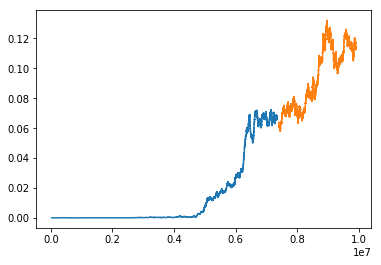

In [13]:
plt.figure()
plt.plot(train.index.values, train['2017_songs_frac'], '-',
        train.shape[0] + test.index.values, test['2017_songs_frac'], '-');

In [14]:
len(train)

7377418

In [15]:
len(train)*.8

5901934.4

In [16]:
7377418-5901934

1475484

In [17]:
#msk = np.random.rand(len(train)) < 0.8 # this is the standard shuffle split, but using this would break the data. 
msk= np.ones(5901934)

msk2=np.zeros(1475484)
msk3=np.concatenate((msk,msk2))
msk4= msk3>.5
data_train = train
data_test = train[~msk4]

In [18]:
msk4

array([ True,  True,  True, ..., False, False, False], dtype=bool)

In [19]:
data_train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,artist_name,genre_ids,song_length,language,...,artist_id_emb,song_id_emb,genre_id_emb,language_id_emb,sourcet_id_emb,sourcest_id_emb,scn_id_emb,song_year_emb,city_id_emb,2017_songs_frac
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,Bastille,359,206471.0,52.0,...,24843,347544,563,5,11,6,5,98,0,NaN
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,Various Artists,1259,284584.0,52.0,...,37929,190866,59,5,3,7,6,81,11,NaN
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,Nas,1259,225396.0,52.0,...,1201,20685,59,5,3,7,6,88,11,NaN
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,Soundway,1019,255512.0,-1.0,...,14497,301565,165,8,3,7,6,92,11,NaN
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,Brett Young,1011,187802.0,52.0,...,7144,260006,509,5,11,6,5,98,0,NaN


In [20]:
data_train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'artist_name', 'genre_ids', 'song_length',
       'language', 'city', 'bd', 'gender', 'registered_via', 'expiration_date',
       'registration_year', 'registration_month', 'registration_date',
       'expiration_year', 'expiration_month', 'song_year', 'index_number',
       'year_scaled', 'year_stand_scaled', 'user_id_emb', 'artist_id_emb',
       'song_id_emb', 'genre_id_emb', 'language_id_emb', 'sourcet_id_emb',
       'sourcest_id_emb', 'scn_id_emb', 'song_year_emb', 'city_id_emb',
       '2017_songs_frac'],
      dtype='object')

In [21]:
data_train_lgb=data_train.select_dtypes(include=[np.number], exclude=None)
data_test_lgb=data_test.select_dtypes(include=[np.number], exclude=None)

In [22]:
test_lgb= test.select_dtypes(include=[np.number], exclude=None)

LGB baseline.

In [23]:

import gc
#del members, songs; gc.collect();



X_train = np.array(data_train_lgb.drop(['target'], axis=1))
y_train = data_train_lgb['target'].values
X_valid = np.array(data_test_lgb.drop(['target'], axis=1))
y_valid = data_test_lgb['target'].values

X_test = np.array(test_lgb.drop(['id'], axis=1))
ids = test_lgb['id'].values



    

d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid) 

watchlist = [d_train, d_valid]


print('Training LGBM model...')
params = {}
params['learning_rate'] = 0.35
params['application'] = 'binary'
params['max_depth'] = 14
params['num_leaves'] = 2**8
params['verbosity'] = 0
params['metric'] = 'auc'

model = lgb.train(params, train_set=d_train, num_boost_round=45, valid_sets=watchlist, \
early_stopping_rounds=10, verbose_eval=10)

print('Making predictions and saving them...')
p_train_test_lgb = model.predict(X_valid)
p_test_lgb = model.predict(X_test)
p_train_rain_lgb = model.predict(X_train)



Training LGBM model...
Training until validation scores don't improve for 10 rounds.
[10]	training's auc: 0.721118	valid_1's auc: 0.664572
[20]	training's auc: 0.739621	valid_1's auc: 0.689636
[30]	training's auc: 0.750558	valid_1's auc: 0.705253
[40]	training's auc: 0.758612	valid_1's auc: 0.716089
Making predictions and saving them...


In [24]:
# now to confirm I haven't messed with anything
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,artist_name,genre_ids,song_length,language,...,artist_id_emb,song_id_emb,genre_id_emb,language_id_emb,sourcet_id_emb,sourcest_id_emb,scn_id_emb,song_year_emb,city_id_emb,2017_songs_frac
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,Bastille,359,206471.0,52.0,...,24843,347544,563,5,11,6,5,98,0,NaN
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,Various Artists,1259,284584.0,52.0,...,37929,190866,59,5,3,7,6,81,11,NaN
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,Nas,1259,225396.0,52.0,...,1201,20685,59,5,3,7,6,88,11,NaN
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,Soundway,1019,255512.0,-1.0,...,14497,301565,165,8,3,7,6,92,11,NaN
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,Brett Young,1011,187802.0,52.0,...,7144,260006,509,5,11,6,5,98,0,NaN


In [25]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type,artist_name,genre_ids,song_length,language,...,artist_id_emb,song_id_emb,genre_id_emb,language_id_emb,sourcet_id_emb,sourcest_id_emb,scn_id_emb,song_year_emb,city_id_emb,2017_songs_frac
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,梁文音 (Rachel Liang),458,224130.0,3.0,...,44270,241006,549,0,9,7,6,96,0,NaN
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,林俊傑 (JJ Lin),465,320470.0,3.0,...,44814,285212,108,0,9,7,6,92,0,NaN
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,-1,song-based-playlist,Yu Takahashi (高橋優),2022,315899.0,17.0,...,2109,118788,87,4,6,1,22,92,0,NaN
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio,U2,465,285210.0,52.0,...,23063,287878,108,5,7,2,17,84,1,NaN
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio,Yoga Mr Sound,873,197590.0,-1.0,...,38624,144171,458,8,7,2,17,93,1,NaN


In [26]:
data_train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,artist_name,genre_ids,song_length,language,...,artist_id_emb,song_id_emb,genre_id_emb,language_id_emb,sourcet_id_emb,sourcest_id_emb,scn_id_emb,song_year_emb,city_id_emb,2017_songs_frac
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,Bastille,359,206471.0,52.0,...,24843,347544,563,5,11,6,5,98,0,NaN
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,Various Artists,1259,284584.0,52.0,...,37929,190866,59,5,3,7,6,81,11,NaN
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,Nas,1259,225396.0,52.0,...,1201,20685,59,5,3,7,6,88,11,NaN
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,Soundway,1019,255512.0,-1.0,...,14497,301565,165,8,3,7,6,92,11,NaN
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,Brett Young,1011,187802.0,52.0,...,7144,260006,509,5,11,6,5,98,0,NaN


In [27]:
data_test.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,artist_name,genre_ids,song_length,language,...,artist_id_emb,song_id_emb,genre_id_emb,language_id_emb,sourcet_id_emb,sourcest_id_emb,scn_id_emb,song_year_emb,city_id_emb,2017_songs_frac
5901934,+fzJ5Uou/rxl1pXlebOEBHFKC4LBwDfgnc2R7287CVs=,JTVy3aCLoTFkqPK4pkGBy0YTlH0zpkubCoKMh07WYfM=,my library,Local playlist more,local-library,1,楊韻禾 (Melody Yeung),465,259553.0,3.0,...,20632,296926,108,0,9,7,6,89,0,0.02136
5901935,+fzJ5Uou/rxl1pXlebOEBHFKC4LBwDfgnc2R7287CVs=,2TR1fCpa5/ac/xe+hdOe52nBZ6afSU49gsGQbhTQVzk=,my library,Local playlist more,local-library,0,倪安東 (Anthony Neely),465,191738.0,3.0,...,2587,115811,108,0,9,7,6,94,0,0.02136
5901936,+fzJ5Uou/rxl1pXlebOEBHFKC4LBwDfgnc2R7287CVs=,wev1Fi6KYkCSFAstQfhxJPZv7wkn8wGepys+KDmeBy4=,my library,Local playlist more,local-library,1,Various Artists,359,204521.0,52.0,...,37929,372208,563,5,9,7,6,98,0,0.02136
5901937,v04FgzXSdai5doJPrcwbrQTMbnETwLB5Li0t36X6kSQ=,NhQfOVnptpW5z5qsP/sN+hVS8TM2iYvdy/ZGVe7K+kM=,my library,Local playlist more,local-library,1,Rae Sremmurd,1259,291828.0,52.0,...,14534,318801,59,5,9,7,6,98,0,0.02136
5901938,Rw5fS0aEzNBUaVMFQLpD2oW11xH2Jv107h49EUVXiTM=,OakhL7CLirelAGEP9sYyP6fmTa8HV1mD/qVdpM6o5uE=,discover,Online playlist more,online-playlist,1,G.E.M.鄧紫棋,-1,258821.0,3.0,...,10010,145775,608,0,11,1,12,94,2,0.02136


XGB baseline

In [28]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label=y_valid) 
d_test = xgb.DMatrix(X_test)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
#del X_train, X_valid, y_train, y_valid

# Train model, evaluate and make predictions
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.35
params['max_depth'] = 14
params['silent'] = 1
params['eval_metric'] = 'auc'

model = xgb.train(params, d_train, 20, watchlist, early_stopping_rounds=10, \
    maximize=True, verbose_eval=5)


p_train_test_xgb = model.predict(d_valid)
p_test_xgb = model.predict(d_test)
p_train_train_xgb = model.predict(d_train)

# Prepare submission
#print(len(ids), len(p_test))
#subm = pd.DataFrame()
#subm['id'] = ids
#subm['target'] = p_test
#subm.to_csv('submission.csv', index=False)

[0]	train-auc:0.725163	valid-auc:0.669352
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[5]	train-auc:0.765172	valid-auc:0.722498
[10]	train-auc:0.788846	valid-auc:0.753067
[15]	train-auc:0.808203	valid-auc:0.779141


In [29]:
train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'artist_name', 'genre_ids', 'song_length',
       'language', 'city', 'bd', 'gender', 'registered_via', 'expiration_date',
       'registration_year', 'registration_month', 'registration_date',
       'expiration_year', 'expiration_month', 'song_year', 'index_number',
       'year_scaled', 'year_stand_scaled', 'user_id_emb', 'artist_id_emb',
       'song_id_emb', 'genre_id_emb', 'language_id_emb', 'sourcet_id_emb',
       'sourcest_id_emb', 'scn_id_emb', 'song_year_emb', 'city_id_emb',
       '2017_songs_frac'],
      dtype='object')

time for embeddings, this way the embedded columns dont end up adding too many features for the boosted tree methods. 
below is a large code block, but all it's doing is creating dictionaries of every unqiue value across the data set, then making 'embedding' columns which are ints which can be fed to a neural net. The reason this code is repeated, rather than a pipline/function is that dictionaries having names allows you to go backwards from embeddings to original values,

In [30]:
def embedding_input_song(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_song_Hidden_Factors')(inp)
def embedding_input_user(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_User_Hidden_Factors')(inp)
def embedding_input_genre(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_genre_Hidden_Factors')(inp)
def embedding_input_artist(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_artist_Hidden_Factors')(inp)

user_in1, u1 = embedding_input_user('user_id_in', n_users, 24, 1e-4) # the extra 15 is headroom for unused embeddings in the recommendation stae. 
artist_in1, a1 = embedding_input_artist('artist_id_in', n_artists, 24, 1e-4)
song_in1, s1 = embedding_input_song('song_id_in', n_songs, 24, 1e-4) # the extra 15 is headroom for unused embeddings in the recommendation stae. 
genre_in1, g1 = embedding_input_genre('genre_id_in', n_genres, 12, 1e-4)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(34403, 24, input_length=1, embeddings_regularizer=<keras.reg..., name="Embed_User_Hidden_Factors")`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(46373, 24, input_length=1, embeddings_regularizer=<keras.reg..., name="Embed_artist_Hidden_Factors")`
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(419839, 24, input_length=1, embeddings_regularizer=<keras.reg..., name="Embed_song_Hidden_Factors")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(609, 12, input_length=1, embeddings_reg

In [31]:
# nn1_ for status prediction
x = merge([u1, a1,s1,g1], mode='concat', name='All_Factors_on_one_layer')
x = Flatten()(x)
x = Dropout(0.1, name='Prevent_overfit3')(x) # this layer made the model worse. 
x = Dense(64, activation='relu',name='Random_HF_Interactions')(x)
x = Dropout(0.35,name='Prevent_overfit2')(x)
x = Dense(18, activation='relu',name='Random_HF_Interactions2')(x)
x = Dropout(0.1, name='Prevent_overfit')(x)
x = Dense(1,name='Final_Interactions',activation='sigmoid')(x)

nn1 = Model([user_in1, artist_in1,song_in1,genre_in1], x)
nn1.compile(Adam(0.001), loss='binary_crossentropy',metrics=['accuracy'])


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/usr/local/lib/python3.5/dist-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [32]:
nn1.fit([data_train.user_id_emb, data_train.artist_id_emb,data_train.song_id_emb,data_train.genre_id_emb], data_train.target, batch_size=9120, epochs=4, 
          validation_data=([data_test.user_id_emb, data_test.artist_id_emb,data_test.song_id_emb,data_test.genre_id_emb], data_test.target))

Train on 7377418 samples, validate on 1475484 samples
Epoch 1/4
7377418/7377418 [==============================] - 19s - loss: 0.6596 - acc: 0.6548 - val_loss: 0.6432 - val_acc: 0.6579
Epoch 2/4
7377418/7377418 [==============================] - 18s - loss: 0.6304 - acc: 0.6735 - val_loss: 0.6345 - val_acc: 0.6731
Epoch 3/4
7377418/7377418 [==============================] - 17s - loss: 0.6269 - acc: 0.6818 - val_loss: 0.6268 - val_acc: 0.6824
Epoch 4/4
7377418/7377418 [==============================] - 18s - loss: 0.6241 - acc: 0.6859 - val_loss: 0.6224 - val_acc: 0.6877


In [33]:
nn1.fit([data_train.user_id_emb, data_train.artist_id_emb,data_train.song_id_emb,data_train.genre_id_emb], data_train.target, batch_size=19120, epochs=9, 
          validation_data=([data_test.user_id_emb, data_test.artist_id_emb,data_test.song_id_emb,data_test.genre_id_emb], data_test.target))

Train on 7377418 samples, validate on 1475484 samples
Epoch 1/9
7377418/7377418 [==============================] - 14s - loss: 0.6088 - acc: 0.6947 - val_loss: 0.6037 - val_acc: 0.6982
Epoch 2/9
7377418/7377418 [==============================] - 13s - loss: 0.6081 - acc: 0.6954 - val_loss: 0.6030 - val_acc: 0.6994
Epoch 3/9
7377418/7377418 [==============================] - 14s - loss: 0.6083 - acc: 0.6961 - val_loss: 0.6049 - val_acc: 0.6980
Epoch 4/9
7377418/7377418 [==============================] - 14s - loss: 0.6081 - acc: 0.6969 - val_loss: 0.6036 - val_acc: 0.7000
Epoch 5/9
7377418/7377418 [==============================] - 13s - loss: 0.6080 - acc: 0.6976 - val_loss: 0.6019 - val_acc: 0.7017
Epoch 6/9
7377418/7377418 [==============================] - 14s - loss: 0.6077 - acc: 0.6981 - val_loss: 0.5992 - val_acc: 0.7049
Epoch 7/9
7377418/7377418 [==============================] - 14s - loss: 0.6075 - acc: 0.6985 - val_loss: 0.5979 - val_acc: 0.7055
Epoch 8/9
7377418/7377418 [==

In [34]:
data_test.index

Int64Index([5901934, 5901935, 5901936, 5901937, 5901938, 5901939, 5901940,
            5901941, 5901942, 5901943,
            ...
            7377408, 7377409, 7377410, 7377411, 7377412, 7377413, 7377414,
            7377415, 7377416, 7377417],
           dtype='int64', length=1475484)

In [35]:
def embedding_input_song(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_song_Hidden_Factors')(inp)
def embedding_input_user(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_User_Hidden_Factors')(inp)
def embedding_input_genre(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_genre_Hidden_Factors')(inp)
def embedding_input_artist(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_artist_Hidden_Factors')(inp)
def embedding_input_song_year(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_song_year_Hidden_Factors')(inp)

user_in3, u3 = embedding_input_user('user_id_in', n_users, 24, 1e-4) # the extra 15 is headroom for unused embeddings in the recommendation stae. 
artist_in3, a3 = embedding_input_artist('artist_id_in', n_artists, 24, 1e-4)
song_in3, s3 = embedding_input_song('song_id_in', n_songs, 24, 1e-4) # the extra 15 is headroom for unused embeddings in the recommendation stae. 
genre_in3, g3 = embedding_input_genre('genre_id_in', n_genres, 12, 1e-4)
song_year_in3, sy3 = embedding_input_song_year('song_year_in', n_years, 12, 1e-4)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(34403, 24, input_length=1, embeddings_regularizer=<keras.reg..., name="Embed_User_Hidden_Factors")`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(46373, 24, input_length=1, embeddings_regularizer=<keras.reg..., name="Embed_artist_Hidden_Factors")`
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(419839, 24, input_length=1, embeddings_regularizer=<keras.reg..., name="Embed_song_Hidden_Factors")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(609, 12, input_length=1, embeddings_reg

In [36]:
# nn1_ for status prediction
x = merge([u3, a3,s3,g3,sy3], mode='concat', name='All_Factors_on_one_layer')
x = Flatten()(x)
x = Dropout(0.25, name='Prevent_overfit3')(x) # this layer made the model worse. 
x = Dense(74, activation='relu',name='Random_HF_Interactions')(x)
x = Dropout(0.35,name='Prevent_overfit2')(x)
x = Dense(18, activation='relu',name='Random_HF_Interactions2')(x)
x = Dropout(0.1, name='Prevent_overfit')(x)
x = Dense(1,name='Final_Interactions',activation='sigmoid')(x)

nn3 = Model([user_in3, artist_in3,song_in3,genre_in3,song_year_in3], x)
nn3.compile(Adam(0.001), loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/usr/local/lib/python3.5/dist-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [37]:
nn3.fit([data_train.user_id_emb, data_train.artist_id_emb,data_train.song_id_emb,data_train.genre_id_emb,data_train.song_year_emb], data_train.target, batch_size=7120, epochs=2, 
          validation_data=([data_test.user_id_emb, data_test.artist_id_emb,data_test.song_id_emb,data_test.genre_id_emb,data_test.song_year_emb], data_test.target))

Train on 7377418 samples, validate on 1475484 samples
Epoch 1/2
7377418/7377418 [==============================] - 23s - loss: 0.6597 - acc: 0.6534 - val_loss: 0.6499 - val_acc: 0.6543
Epoch 2/2
7377418/7377418 [==============================] - 23s - loss: 0.6373 - acc: 0.6711 - val_loss: 0.6414 - val_acc: 0.6689


In [38]:
nn3.fit([data_train.user_id_emb, data_train.artist_id_emb,data_train.song_id_emb,data_train.genre_id_emb,data_train.song_year_emb], data_train.target, batch_size=19120, epochs=6, 
          validation_data=([data_test.user_id_emb, data_test.artist_id_emb,data_test.song_id_emb,data_test.genre_id_emb,data_test.song_year_emb], data_test.target))

Train on 7377418 samples, validate on 1475484 samples
Epoch 1/6
7377418/7377418 [==============================] - 15s - loss: 0.6200 - acc: 0.6837 - val_loss: 0.6188 - val_acc: 0.6843.683
Epoch 2/6
7377418/7377418 [==============================] - 15s - loss: 0.6180 - acc: 0.6855 - val_loss: 0.6185 - val_acc: 0.6854
Epoch 3/6
7377418/7377418 [==============================] - 15s - loss: 0.6178 - acc: 0.6863 - val_loss: 0.6155 - val_acc: 0.6886
Epoch 4/6
7377418/7377418 [==============================] - 15s - loss: 0.6174 - acc: 0.6874 - val_loss: 0.6149 - val_acc: 0.6904
Epoch 5/6
7377418/7377418 [==============================] - 15s - loss: 0.6170 - acc: 0.6888 - val_loss: 0.6145 - val_acc: 0.6916
Epoch 6/6
7377418/7377418 [==============================] - 15s - loss: 0.6165 - acc: 0.6897 - val_loss: 0.6132 - val_acc: 0.6936


In [39]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type,artist_name,genre_ids,song_length,language,...,artist_id_emb,song_id_emb,genre_id_emb,language_id_emb,sourcet_id_emb,sourcest_id_emb,scn_id_emb,song_year_emb,city_id_emb,2017_songs_frac
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,梁文音 (Rachel Liang),458,224130.0,3.0,...,44270,241006,549,0,9,7,6,96,0,NaN
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,林俊傑 (JJ Lin),465,320470.0,3.0,...,44814,285212,108,0,9,7,6,92,0,NaN
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,-1,song-based-playlist,Yu Takahashi (高橋優),2022,315899.0,17.0,...,2109,118788,87,4,6,1,22,92,0,NaN
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio,U2,465,285210.0,52.0,...,23063,287878,108,5,7,2,17,84,1,NaN
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio,Yoga Mr Sound,873,197590.0,-1.0,...,38624,144171,458,8,7,2,17,93,1,NaN


In [40]:
def embedding_input_song(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_song_Hidden_Factors')(inp)
def embedding_input_user(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_User_Hidden_Factors')(inp)
def embedding_input_genre(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_genre_Hidden_Factors')(inp)
def embedding_input_artist(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_artist_Hidden_Factors')(inp)
def embedding_input_sn(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_screenname_Hidden_Factors')(inp)
def embedding_input_sourcet(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_sourcet_Hidden_Factors')(inp)
def embedding_input_sourcest(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_sourcest_Hidden_Factors')(inp)
def embedding_input_language(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_language_Hidden_Factors')(inp)
def embedding_input_song_year(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Embed_song_year_Hidden_Factors')(inp)



user_in5, u5 = embedding_input_user('user_id_in', n_users, 24, 1e-5) # the extra 15 is headroom for unused embeddings in the recommendation stae. 
artist_in5, a5 = embedding_input_artist('artist_id_in', n_artists, 24, 1e-5)
song_in5, s5 = embedding_input_song('song_id_in', n_songs, 24, 1e-5) # the extra 15 is headroom for unused embeddings in the recommendation stae. 
genre_in5, g5 = embedding_input_genre('genre_id_in', n_genres, 12, 1e-5)
sname_in5, sn5 = embedding_input_sn('sn_id_in',n_sns,4,1e-5)
sourcet_in5, st5 = embedding_input_sourcet('sourcet_id_in',n_sourcet,4,1e-5)
sourcest_in5, sst5 = embedding_input_sourcest('sourcest_id_in',n_sourcest,4,1e-5)
languages_in5, l5 = embedding_input_language('language_id_in',n_languages,4,1e-5)
song_year_in5, sy5 = embedding_input_song_year('song_year_in', n_years, 12, 1e-5)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(34403, 24, input_length=1, embeddings_regularizer=<keras.reg..., name="Embed_User_Hidden_Factors")`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(46373, 24, input_length=1, embeddings_regularizer=<keras.reg..., name="Embed_artist_Hidden_Factors")`
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(419839, 24, input_length=1, embeddings_regularizer=<keras.reg..., name="Embed_song_Hidden_Factors")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(609, 12, input_length=1, embeddings_reg

In [41]:
# nn1_ for status prediction
x = merge([u5, a5,s5,g5,sn5,st5,sst5,l5,sy5], mode='concat', name='All_Factors_on_one_layer')
x = Flatten()(x)
x = Dropout(0.55, name='Prevent_overfit3')(x) # this layer made the model worse. 
x = Dense(74, activation='relu',name='Random_HF_Interactions')(x)
x = Dropout(0.35,name='Prevent_overfit2')(x)
x = Dense(16, activation='relu',name='Random_HF_Interactions2')(x)
x = Dropout(0.1, name='Prevent_overfit')(x)
x = Dense(1,name='Final_Interactions',activation='sigmoid')(x)

nn5 = Model([user_in5, artist_in5,song_in5,genre_in5,sname_in5,sourcet_in5,sourcest_in5,languages_in5,song_year_in5], x)
nn5.compile(Adam(0.001), loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/usr/local/lib/python3.5/dist-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [42]:
nn5.fit([data_train.user_id_emb, data_train.artist_id_emb,data_train.song_id_emb,data_train.genre_id_emb, data_train.scn_id_emb,data_train.sourcet_id_emb,data_train.sourcest_id_emb,data_train.language_id_emb,data_train.song_year_emb], data_train.target, batch_size=5120, epochs=3, 
          validation_data=([data_test.user_id_emb, data_test.artist_id_emb,data_test.song_id_emb,data_test.genre_id_emb,data_test.scn_id_emb,data_test.sourcet_id_emb,data_test.sourcest_id_emb,data_test.language_id_emb, data_test.song_year_emb], data_test.target))

Train on 7377418 samples, validate on 1475484 samples
Epoch 1/3
7377418/7377418 [==============================] - 36s - loss: 0.6064 - acc: 0.6827 - val_loss: 0.6017 - val_acc: 0.6913
Epoch 2/3
7377418/7377418 [==============================] - 34s - loss: 0.5910 - acc: 0.6993 - val_loss: 0.5949 - val_acc: 0.6983
Epoch 3/3
7377418/7377418 [==============================] - 35s - loss: 0.5886 - acc: 0.7022 - val_loss: 0.5916 - val_acc: 0.7021


In [43]:
nn5.fit([data_train.user_id_emb, data_train.artist_id_emb,data_train.song_id_emb,data_train.genre_id_emb, data_train.scn_id_emb,data_train.sourcet_id_emb,data_train.sourcest_id_emb,data_train.language_id_emb,data_train.song_year_emb], data_train.target, batch_size=25120, epochs=7, 
          validation_data=([data_test.user_id_emb, data_test.artist_id_emb,data_test.song_id_emb,data_test.genre_id_emb,data_test.scn_id_emb,data_test.sourcet_id_emb,data_test.sourcest_id_emb,data_test.language_id_emb, data_test.song_year_emb], data_test.target))

Train on 7377418 samples, validate on 1475484 samples
Epoch 1/7
7377418/7377418 [==============================] - 19s - loss: 0.5791 - acc: 0.7087 - val_loss: 0.5808 - val_acc: 0.7084
Epoch 2/7
7377418/7377418 [==============================] - 19s - loss: 0.5750 - acc: 0.7108 - val_loss: 0.5773 - val_acc: 0.7111
Epoch 3/7
7377418/7377418 [==============================] - 19s - loss: 0.5738 - acc: 0.7116 - val_loss: 0.5750 - val_acc: 0.7129
Epoch 4/7
7377418/7377418 [==============================] - 19s - loss: 0.5733 - acc: 0.7123 - val_loss: 0.5759 - val_acc: 0.7125
Epoch 5/7
7377418/7377418 [==============================] - 19s - loss: 0.5731 - acc: 0.7125 - val_loss: 0.5740 - val_acc: 0.7137
Epoch 6/7
7377418/7377418 [==============================] - 19s - loss: 0.5730 - acc: 0.7129 - val_loss: 0.5735 - val_acc: 0.7148
Epoch 7/7
7377418/7377418 [==============================] - 19s - loss: 0.5730 - acc: 0.7133 - val_loss: 0.5733 - val_acc: 0.7152


Ensembling:
part 1 is to make a mean ensemble and lr ensemble, and test them against my validation data. 
Part 2 is to try a stacked model that uses the prior model's data as inputs.  


In [44]:
lgbpred_train_test= p_test_lgb
xgbpred_train_test= p_test_xgb
nnpred1_train_test=nn1.predict([test.user_id_emb, test.artist_id_emb,test.song_id_emb,test.genre_id_emb])
nnpred3_train_test=nn3.predict([test.user_id_emb, test.artist_id_emb,test.song_id_emb,test.genre_id_emb,test.song_year_emb])
nnpred5_train_test=nn5.predict([test.user_id_emb, test.artist_id_emb,test.song_id_emb,test.genre_id_emb,test.scn_id_emb,test.sourcet_id_emb,test.sourcest_id_emb,test.language_id_emb,test.song_year_emb])

In [46]:
test['lgb_pred']= lgbpred_train_test
test['xgb_pred']= xgbpred_train_test
test['nn1_pred']= nnpred1_train_test
test['nn3_pred']=nnpred3_train_test
test['nn5_pred']=nnpred5_train_test
test['predsum']=test['lgb_pred']+test['xgb_pred']+test['nn3_pred']+test['nn5_pred']
test['predmean']=test['predsum']*.25
test['target']=test['predmean']
sub= test[['id','target']]


In [47]:
sub.to_csv('submission_blog_post_ensembled.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

In [48]:
sub.head()

,id,target
0,0,0.380752
1,1,0.413328
2,2,0.140648
3,3,0.169187
4,4,0.155661


Results:
0.67844 is what we get on kaggle. 
0.68544888208841592 is what we expected to get. 
At time of submission this put 1 away from the top 10 percent of submissions  (43 out of 420)

Next steps:
More research. 

Lesson learned:
Once you've selected a good test set, you can tune your models and have a good idea of how your model will perform on new data (if you do randomized train test split (stratified or not), with the same models in the same ensemble, it will severly overfit and perform much worse. ) 


bonus round: LR overfit. 
let's use a kaggle submission to prove that an lr based on the outputs of this model is overfit. I intentionally tuned the model to not overfit based on the time series, which mean that same hyperparameters could be applied to a larger data set. 
We expect a result of roughly .65

In [54]:
lgbpred_train_train= p_train_rain_lgb
xgbpred_train_train= p_train_train_xgb
nnpred1_train_train=nn1.predict([data_train.user_id_emb, data_train.artist_id_emb,data_train.song_id_emb,data_train.genre_id_emb])
nnpred3_train_train=nn3.predict([data_train.user_id_emb, data_train.artist_id_emb,data_train.song_id_emb,data_train.genre_id_emb,data_train.song_year_emb])
nnpred5_train_train=nn5.predict([data_train.user_id_emb, data_train.artist_id_emb,data_train.song_id_emb,data_train.genre_id_emb,data_train.scn_id_emb,data_train.sourcet_id_emb,data_train.sourcest_id_emb,data_train.language_id_emb,data_train.song_year_emb])

In [55]:
lgbpred_train_train.shape

(7377418,)

In [56]:
data_train.shape

(7377418, 35)

In [58]:
data_train['lgb_pred']= lgbpred_train_train
data_train['xgb_pred']= xgbpred_train_train
data_train['nn1_pred']= nnpred1_train_train
data_train['nn3_pred']=nnpred3_train_train
data_train['nn5_pred']=nnpred5_train_train
predcompare= data_train[['lgb_pred','xgb_pred','nn1_pred','nn3_pred','nn5_pred','target','year_scaled','year_stand_scaled']]
predcompare['predsum']=data_train['lgb_pred']+data_train['xgb_pred']+data_train['nn1_pred']+data_train['nn3_pred']+data_train['nn5_pred']
predcompare['predmean']=predcompare['predsum']*.2
predcompare['predsum2']=data_train['lgb_pred']+data_train['xgb_pred']+data_train['nn3_pred']+data_train['nn5_pred']
predcompare['predmean2']=predcompare['predsum2']*.25

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [59]:
lr = LogisticRegression()

In [60]:
lr.fit(predcompare[['lgb_pred','xgb_pred','nn1_pred','nn3_pred','nn5_pred','year_stand_scaled']],predcompare['target'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
test['lr']=lr.predict_proba(test[['lgb_pred','xgb_pred','nn1_pred','nn3_pred','nn5_pred','year_stand_scaled']])[:,1]

In [62]:
sub2= test[['id','lr']]

In [63]:
sub2['target']=sub2['lr']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [67]:
sub2.drop('lr',axis=1, inplace=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [68]:
sub2.head()

,id,target
0,0,0.314704
1,1,0.403619
2,2,0.056425
3,3,0.100047
4,4,0.143249


In [69]:
sub2.to_csv('submission_blog_post_lr_overfits.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

In [70]:
sub.head()

,id,target
0,0,0.380752
1,1,0.413328
2,2,0.140648
3,3,0.169187
4,4,0.155661


In [71]:
sub2.head()

,id,target
0,0,0.314704
1,1,0.403619
2,2,0.056425
3,3,0.100047
4,4,0.143249


And the answer was .65054, which is very close to the .651 expected. 

In [83]:
!pip install simplestatistics

  Running setup.py bdist_wheel for simplestatistics ... done
  Stored in directory: /root/.cache/pip/wheels/ce/c7/3a/01c0526f3572acb445dc08e16637e297361f73983b4b383afd
Successfully built simplestatistics


In [84]:
import simplestatistics as stats

In [86]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type,artist_name,genre_ids,song_length,language,...,2017_songs_frac,lgb_pred,xgb_pred,nn1_pred,nn3_pred,nn5_pred,predsum,predmean,target,lr
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,梁文音 (Rachel Liang),458,224130.0,3.0,...,NaN,0.368807,0.396730,0.358824,0.376247,0.381222,1.523006,0.380752,0.380752,0.314704
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,林俊傑 (JJ Lin),465,320470.0,3.0,...,NaN,0.413216,0.465478,0.383217,0.386234,0.388385,1.653312,0.413328,0.413328,0.403619
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,-1,song-based-playlist,Yu Takahashi (高橋優),2022,315899.0,17.0,...,NaN,0.177783,0.169498,0.092521,0.108309,0.107003,0.562594,0.140648,0.140648,0.056425
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio,U2,465,285210.0,52.0,...,NaN,0.139732,0.252176,0.072361,0.195547,0.089295,0.676750,0.169187,0.169187,0.100047
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio,Yoga Mr Sound,873,197590.0,-1.0,...,NaN,0.077510,0.222020,0.209707,0.226199,0.096915,0.622643,0.155661,0.155661,0.143249


In [87]:
harmon= test[['lgb_pred','xgb_pred','nn1_pred','nn3_pred','nn5_pred']]

In [90]:
harmon['target']= harmon[['lgb_pred','xgb_pred','nn1_pred','nn3_pred','nn5_pred']].apply(stats.harmonic_mean)

TypeError: ('harmonic_mean() expects a list or a tuple.', 'occurred at index lgb_pred')

In [98]:
list(harmon[['lgb_pred','xgb_pred','nn1_pred','nn3_pred','nn5_pred']].loc[0].values)

[0.36880704184133739,
 0.39673003554344177,
 0.35882407426834106,
 0.37624698877334595,
 0.38122224807739258]

In [95]:
harmon.shape

(2556790, 5)

In [ ]:
for row in range(0,2556790):
    harmon['target'].loc[row]=stats.harmonic_mean(list(harmon[['lgb_pred','xgb_pred','nn1_pred','nn3_pred','nn5_pred']].loc[row].values))
#making a submission that uses the harmonic mean rather than the normal mean.   

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
harmon['target'].head()

In [ ]:
harmon.head()

In [ ]:
import scipy.stats